In [17]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers

In [8]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


In [10]:
strength = [0.4, 0.4, 0.4, 0.1]

random_flip = layers.RandomFlip(mode="horizontal_and_vertical")
random_crop = layers.RandomCrop(CROP_TO, CROP_TO)
random_brightness = layers.RandomBrightness(0.8 * strength[0])
random_contrast = layers.RandomContrast((1 - 0.8 * strength[1], 1 + 0.8 * strength[1]))
random_saturation = keras_cv.layers.RandomSaturation(
    (0.5 - 0.8 * strength[2], 0.5 + 0.8 * strength[2])
)
random_hue = keras_cv.layers.RandomHue(0.2 * strength[3], [0,255])
grayscale = keras_cv.layers.Grayscale()

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = random_flip(image)
    image = random_crop(image)
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.3, 0.1]):
    x = random_brightness(x)
    x = random_contrast(x)
    x = random_saturation(x)
    x = random_hue(x)
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = ops.clip(x, 0, 255)
    return x


def color_drop(x):
    x = grayscale(x)
    x = ops.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if keras.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

I0000 00:00:1762092503.792396    9743 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8812 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


2025-11-02 15:08:42.100135: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node cond/then/_0/cond/random_brightness_1/Add/_36}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-02 15:08:42.100147: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node cond/then/_0/cond/random_brightness_1/Add/_36}}]]
	 [[GroupCrossDeviceControlEdges_0/cond/then/_0/cond/NoOp/_43]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-02 15:08:42.100152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8975949543661799292
2025-11-02 15:08:42.100157: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/Identity/_47}}]]
	 [[random_flip_1/Add/_10]] [typ

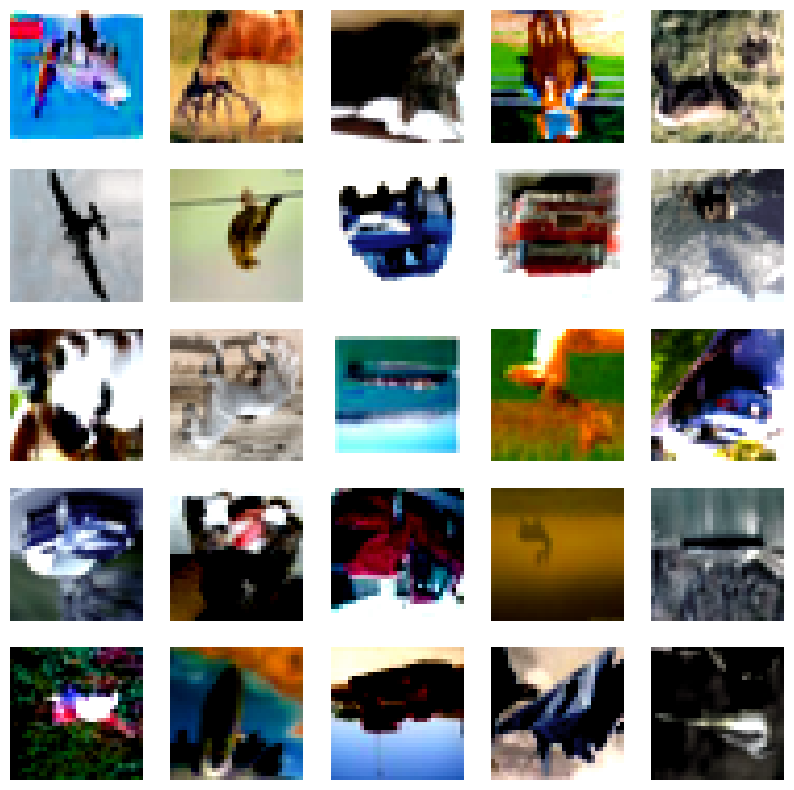

2025-11-02 15:08:42.480942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2426565457736254437
2025-11-02 15:08:42.480958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4959535795963618106
2025-11-02 15:08:42.480962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8975949543661799292
2025-11-02 15:08:42.480966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 104991869415402178
2025-11-02 15:08:42.480969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3986817649665927840
2025-11-02 15:08:42.480974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2426565457736254437
2025-11-02 15:08:42.480978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item

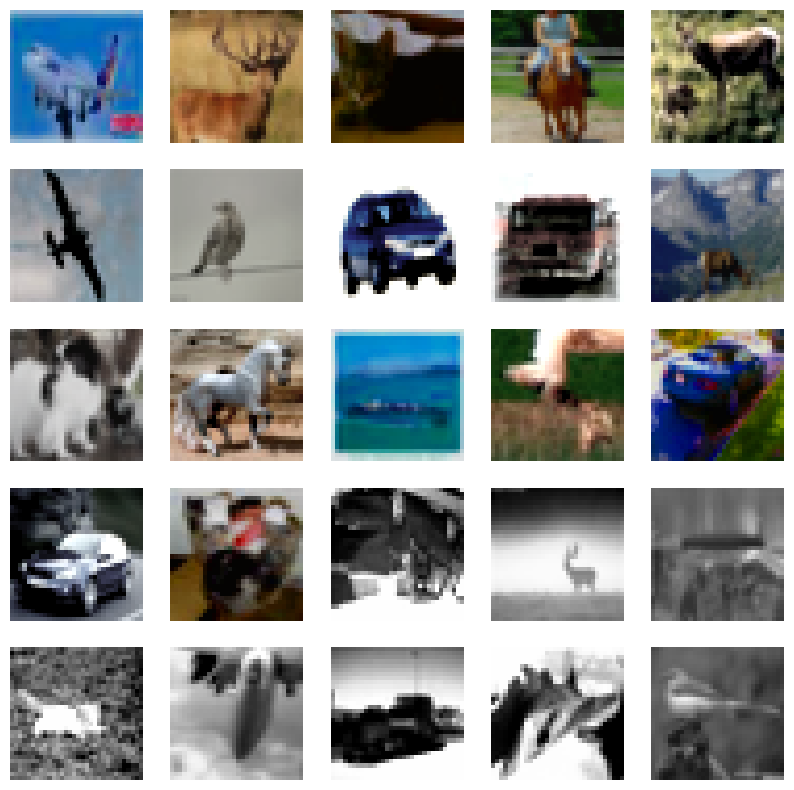

In [11]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [12]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [13]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [14]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = ops.stop_gradient(z)
    p = keras.utils.normalize(p, axis=1, order=2)
    z = keras.utils.normalize(z, axis=1, order=2)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -ops.mean(ops.sum((p * z), axis=1))

In [15]:
class SimSiam(keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/5


2025-11-02 15:10:48.765833: I external/local_xla/xla/service/service.cc:163] XLA service 0x57a06ad862c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-02 15:10:48.765845: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-02 15:10:48.863291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-02 15:10:49.515164: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  5/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: -0.2396

I0000 00:00:1762092654.379922   10061 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - loss: -0.8701
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: -0.8967
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - loss: -0.9064
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - loss: -0.9109
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: -0.9129


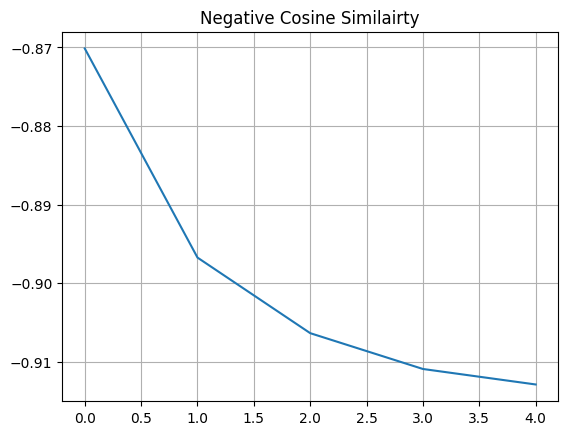

In [18]:
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [19]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1867 - loss: 2.2587 - val_accuracy: 0.2161 - val_loss: 2.2188
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2088 - loss: 2.2034 - val_accuracy: 0.2359 - val_loss: 2.1795
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2228 - loss: 2.1783 - val_accuracy: 0.2339 - val_loss: 2.1619
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2255 - loss: 2.1674 - val_accuracy: 0.2393 - val_loss: 2.1554
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2279 - loss: 2.1643 - val_accuracy: 0.2334 - val_loss: 2.1545
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2161 - loss: 2.2188
Test accuracy: 21.61%
